<a href="https://colab.research.google.com/github/asanneh/CS109B_Final_Project_Group_35/blob/master/CS109B_Final_Project_Group_35.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <div align="center">COMPSCI 109B Final Project - Group 35</div>

# <div align="center"> Project: Measuring the Shape and Brightness of Galaxies with Neural Networks</div>

# <div align='center'> Alpha Sanneh, Brian Tao, Grace Greason, Evan Arnold</div>

## **Data preprocessing**

In [0]:
#install libraries we need here
# !pip install tf_keras_vis
## Please NOTE: you have to install the three libraries below in order to get pymc3 working
# !pip install arviz==0.6.1
# !pip install pymc3==3.8
# !pip install Theano==1.0.4

In [0]:
# Import relevant libraries
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import os
import datetime
import h5py
import matplotlib.pyplot as plt
import pandas.util.testing as tm
from scipy.stats import norm
import matplotlib as mpl
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# Change working directory to where the files needed for the project are stored
file_path = '/content/drive/My Drive/Data'
os.chdir(file_path)
print('Working Directory:',os.getcwd())

Working Directory: /content/drive/My Drive/Data


In [0]:
# Read data
f = h5py.File('Data.h5','r')
image = f['img'][:]    
cat = f['cat'][:]  
label = f['label'][:]   # this gives the set of parameters that characterize the galaxy 
snr = f['snr'][:]
sigma = f['sigma'][:]
image_nonoise = f['img_nonoise'][:]    
image_withnoise = f['img_withnoise'][:]    
f.close()

In [0]:
# Get the shape of images with noise and images without noise
image_withnoise.shape, image_nonoise.shape

((18779, 64, 64), (18779, 64, 64))

## **Visualizing images**

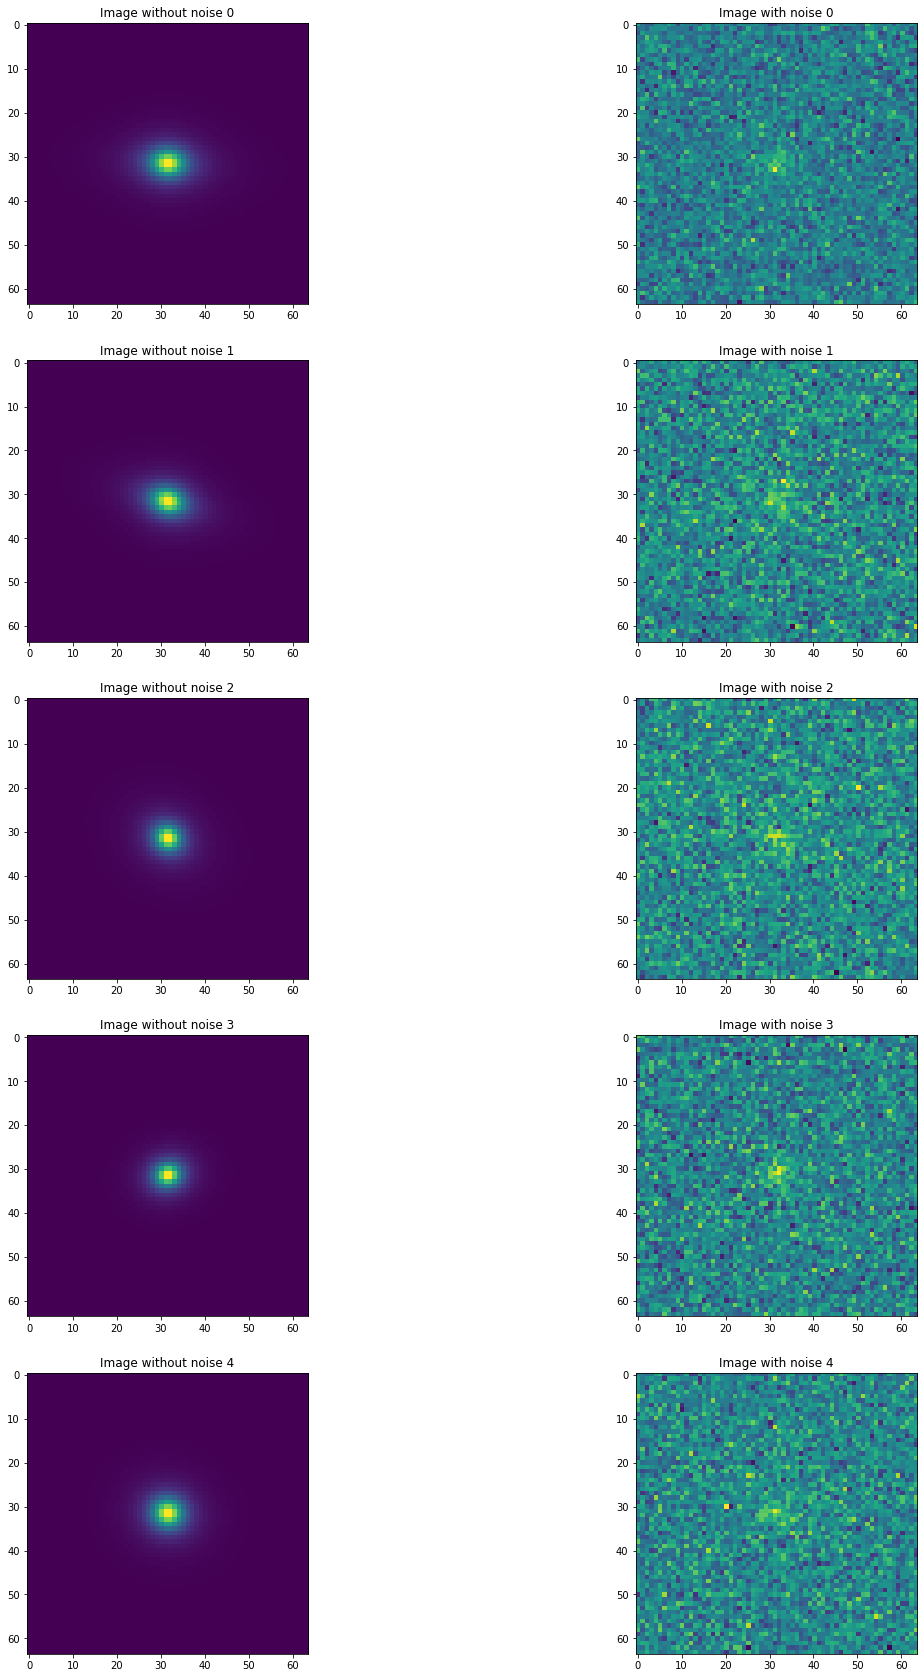

In [0]:
# Plot first five images without noise and with noise
fig, ax = plt.subplots(5,2, figsize=(20,30))
for i in range(5):
    ax[i][0].imshow(image_nonoise[i])
    ax[i][0].set_title('Image without noise {}'.format(i))
    ax[i][1].imshow(image_withnoise[i])
    ax[i][1].set_title('Image with noise {}'.format(i))

## **Inspecting noise** 

Below we plot the histogram of the noise of the dataset along with the best fit normal distribution. We do so to verify that the noise is indeed Gaussian. This will inform our model design. Specifically, it will allow us to model the noise in order to better predict the response.

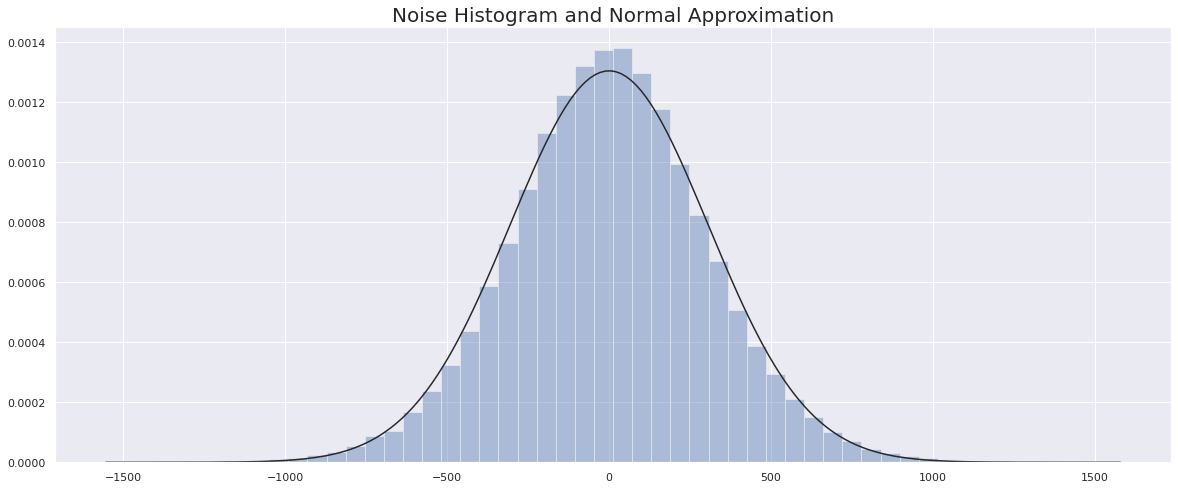

In [0]:

# distribution of noise (first n pixels for efficiency)
sns.set()
n = 100000
# noise
noise = image_withnoise - image_nonoise
noise = noise.reshape(-1, 1)
# plot
fig, ax = plt.subplots(figsize=(20,8))
sns.distplot(noise[1:n], fit=norm, kde=False, ax=ax)
ax.set_title('Noise Histogram and Normal Approximation', fontsize=20);

## **Inspecting the Correlations of the Label Parameters**

As shown below, the response variables have no significant correlation aside from g1 and g2. We expect the scatters of circles as both g1 and g2 are functions of the same variables using different sinusoid functions (cos vs. sin). Care should be taken when modeling g1 and g2 as their outcome is highly correlated (though in a non-linear fashion).

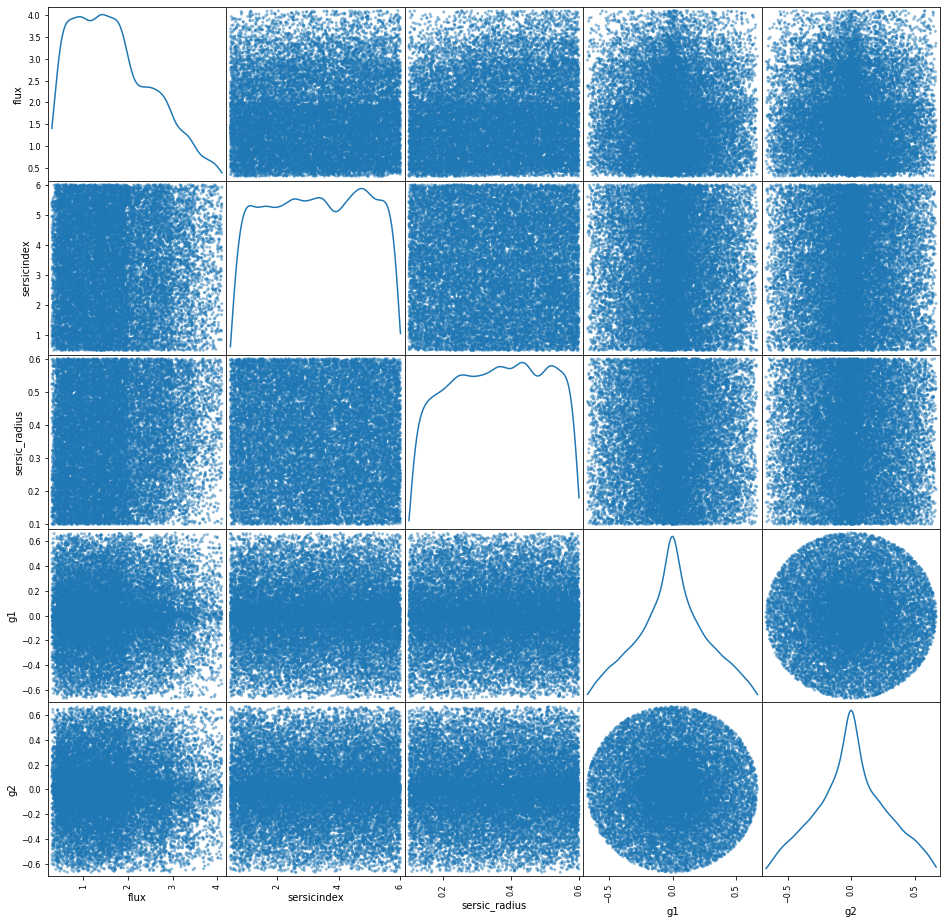

In [0]:
# convert response 2D array to labeled dataframe
label_df = pd.DataFrame(label, columns=['flux', 'sersic' 'index', 'sersic_radius', 'g1', 'g2'])
# scatter matrix of response
pd.plotting.scatter_matrix(label_df, figsize=(16, 16), diagonal='kde');

In [0]:
print(f'Image with noise max: {image_withnoise[0].max()}')
print(f'Image with noise min: {image_withnoise[0].min()}')
print(f'Image with no noise max: {image_nonoise[0].max()}')
print(f'Image with no noise min: {image_nonoise[0].min()}')

Image with noise max: 1088.6094996083598
Image with noise min: -799.6288667294024
Image with no noise max: 455.3077087402344
Image with no noise min: 0.03963421285152435


## **Inspecting the Distributions of the Label Parameters**

We expect Sérsic index and Sérsic radius to be uniformly distributed because they are each randomly generated from a uniform distribution. 

g1 and g2 have the same distribution (and are therefore highly correlated) because they are calcuated using the same mathematical function.


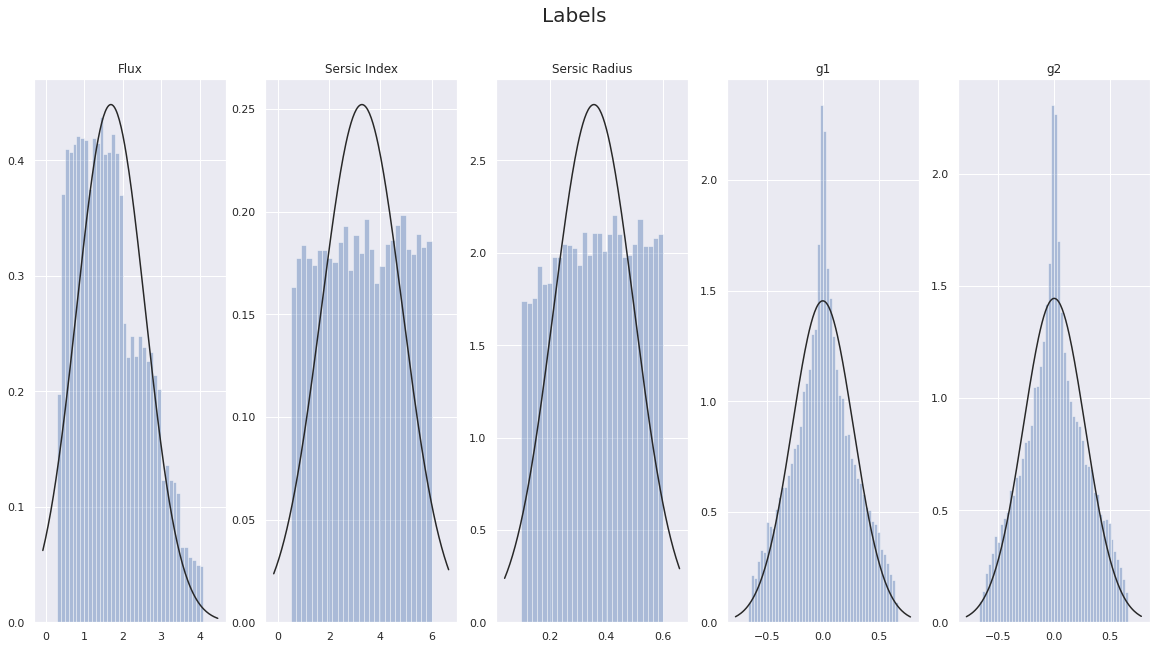

In [0]:
fig, ax = plt.subplots(1,5, figsize=(20,10));
fig.suptitle('Labels', fontsize=20)

sns.distplot(label[:, 0], fit=norm, kde=False,  ax=ax[0]).set_title('Flux')
sns.distplot(label[:, 1], fit=norm, kde=False,  ax=ax[1]).set_title('Sersic Index')
sns.distplot(label[:, 2], fit=norm, kde=False, ax=ax[2]).set_title('Sersic Radius')
sns.distplot(label[:, 3], fit=norm, kde=False, ax=ax[3]).set_title('g1')
sns.distplot(label[:, 4], fit=norm, kde=False, ax=ax[4]).set_title('g2')
plt.show()

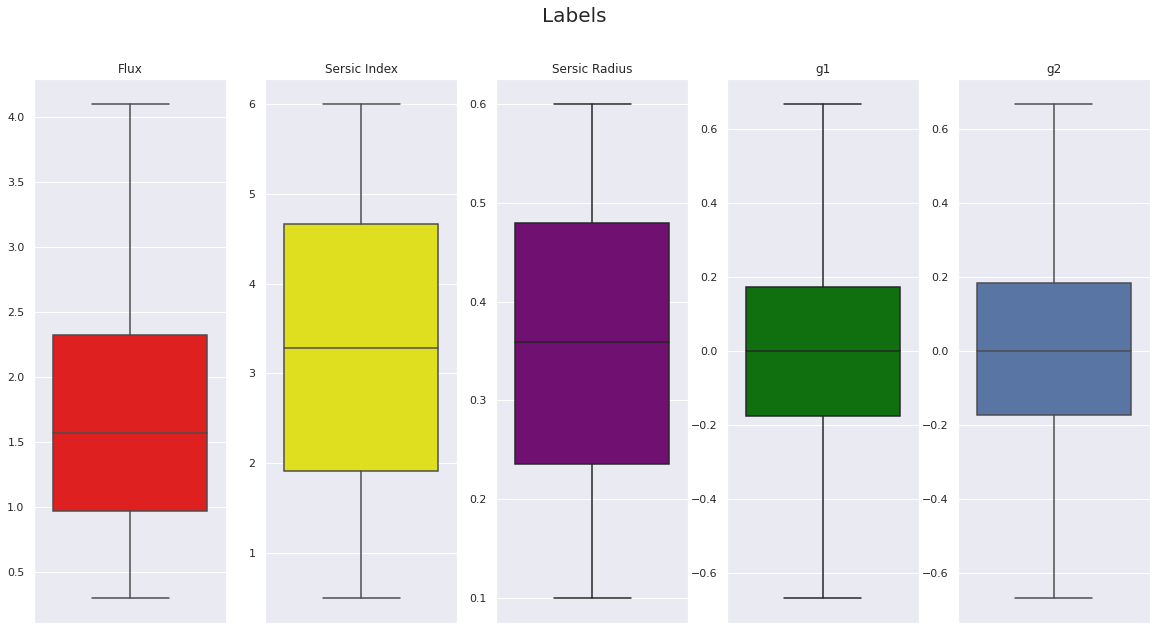

In [0]:
fig, ax = plt.subplots(1,5, figsize=(20,10));
fig.suptitle('Labels')

fig.suptitle('Labels', fontsize=20)
sns.boxplot(label[:, 0],  ax=ax[0], orient='v', color='red').set_title('Flux')
sns.boxplot(label[:, 1],  ax=ax[1], orient='v', color='yellow').set_title('Sersic Index')
sns.boxplot(label[:, 2],  ax=ax[2], orient='v', color='purple').set_title('Sersic Radius')
sns.boxplot(label[:, 3],  ax=ax[3],orient='v', color='green').set_title('g1')
sns.boxplot(label[:, 4],  ax=ax[4], orient='v').set_title('g2')
plt.show()


## **Inspecting Signal-to-Noise Ratio and Sigma**

Next, we plot the distribution of the signal to noise ratio of the galaxies. The code to simulate a galaxy removes all galaxies with ratios less than 10 or greater than 100, which is evident from the distribution.

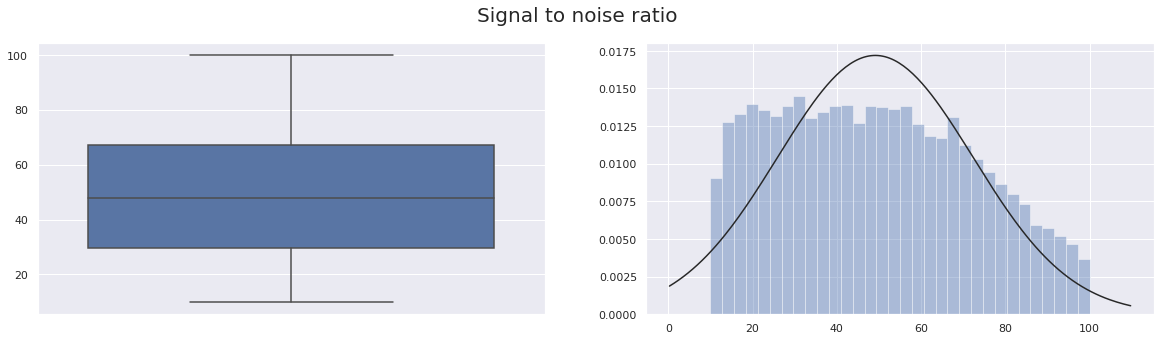

In [0]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
fig.suptitle('Signal to noise ratio', fontsize=20);

sns.boxplot(snr, ax=ax[0], orient='v');
sns.distplot(snr, fit=norm, kde=False, ax=ax[1])
plt.show()


Below is the distribution for sigma, which was used to construct the noise map for each galaxy. As expected, sigma has a uniform distribution.

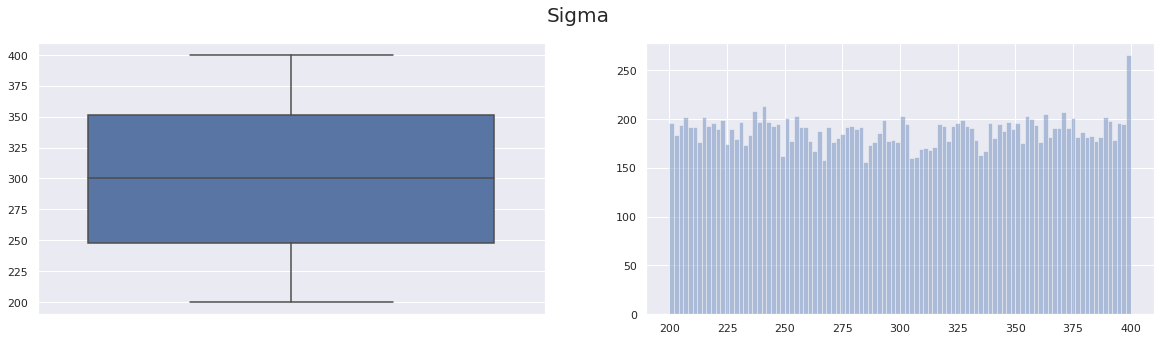

In [0]:
fig, ax = plt.subplots(1,2, figsize=(20,5))
fig.suptitle('Sigma', fontsize=20);

sns.boxplot(sigma, ax=ax[0], orient='v');
sns.distplot(sigma, kde=False, bins=100, ax=ax[1])
plt.show()

## **Key Questions**

**Given everything you have learned, if you faced this data set in the wild, how would you proceed?**

Unfortunately, "noiseless" images of galaxies like the ones we plotted above don't really exist -- signal noise is inherent to the process of taking pictures of objects millions of miles away! If we want to discern key information about the galaxies in our universe -- like flux or Sérsic index --  we must find a way to learn these parameters from the so-called "noisy" images.

We can use supervised learning to create a model that learns the essence of the data -- the actual galaxies. When fed an unfamiliar noisy image, a strong model will ignore the noise and output the galaxy's true parameters.

**What are the important measures?**

The parameters we seek to determine are flux, Sérsic index, Sérsic radius, g1, and g2. We are given images of galaxies that contain stochastic noise at every pixel, and we must train a model that essentially ignores this noise and uses only the actual galaxy to return the previously mentioned parameters.

**What are the right questions to ask, and how can the data answer them?**

We seek to learn the parameters of each galaxy, despite stochastic noise that makes this no easy task. So we ask, is it possible to accurately determine the parameters of a "noisy" galaxy? We can use a data set of noisy galaxies and their known parameters to train a model via supervised learning. Then we can simulate additional noisy galaxies and test our model's ability to accurately find their parameters. If the model performs well on the test set, we know that it has succeeded in ignoring irrelevant information. This finding has important repercussions for astronomers -- it may not be necessary to improve technology to reduce noise in images if we can glean all the information that we need from a noisy image.


## **Model Building and Performance Analysis**

### Baseline models

We create two baseline models to predict flux and Sérsic radius using a dataset in which other parameters, noise, and PSF are held constant. The baseline models are RidgeCV regression and parametric modeling with Markov Chain Monte Carlo (MCMC). 

In [0]:
# Import relevant libraries
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import r2_score
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [6]:
# Set file path to access generated dataset
file_path = '/content/drive/My Drive/Data/Data_flux_radius'
os.chdir(file_path)
print('Working Directory:',os.getcwd())

Working Directory: /content/drive/My Drive/Data/Data_flux_radius


In [0]:
# Read generated dataset
image_no_noise = pd.read_pickle('img_no_noise_flux_radius.pkl')
image_with_noise = pd.read_pickle('img_with_noise_flux_radius.pkl')
labels = pd.read_pickle('labels_flux_radius.pkl')
snr = pd.read_pickle('snr_flux_radius.pkl')

In [8]:
# Print shapes of the dataset
print(f'Shape of image_no_noise: {image_no_noise.shape}')
print(f'Shape of image_with_noise: {image_with_noise.shape}')
print(f'Shape of labels: {labels.shape}')
print(f'Shape of snr: {snr.shape}')

Shape of image_no_noise: (10000, 64, 64)
Shape of image_with_noise: (10000, 64, 64)
Shape of labels: (10000, 5)
Shape of snr: (10000,)


In [9]:
# Observe that Sérsic index, g1, and g2 are fixed
labels[0:5]

array([[ 3.08978209,  3.        ,  0.449856  , -0.0694    ,  0.1515    ],
       [ 3.11185202,  3.        ,  0.83842206, -0.0694    ,  0.1515    ],
       [ 0.98337073,  3.        ,  0.65187262, -0.0694    ,  0.1515    ],
       [ 0.45967895,  3.        ,  0.82260607, -0.0694    ,  0.1515    ],
       [ 3.69849803,  3.        ,  1.13474852, -0.0694    ,  0.1515    ]])

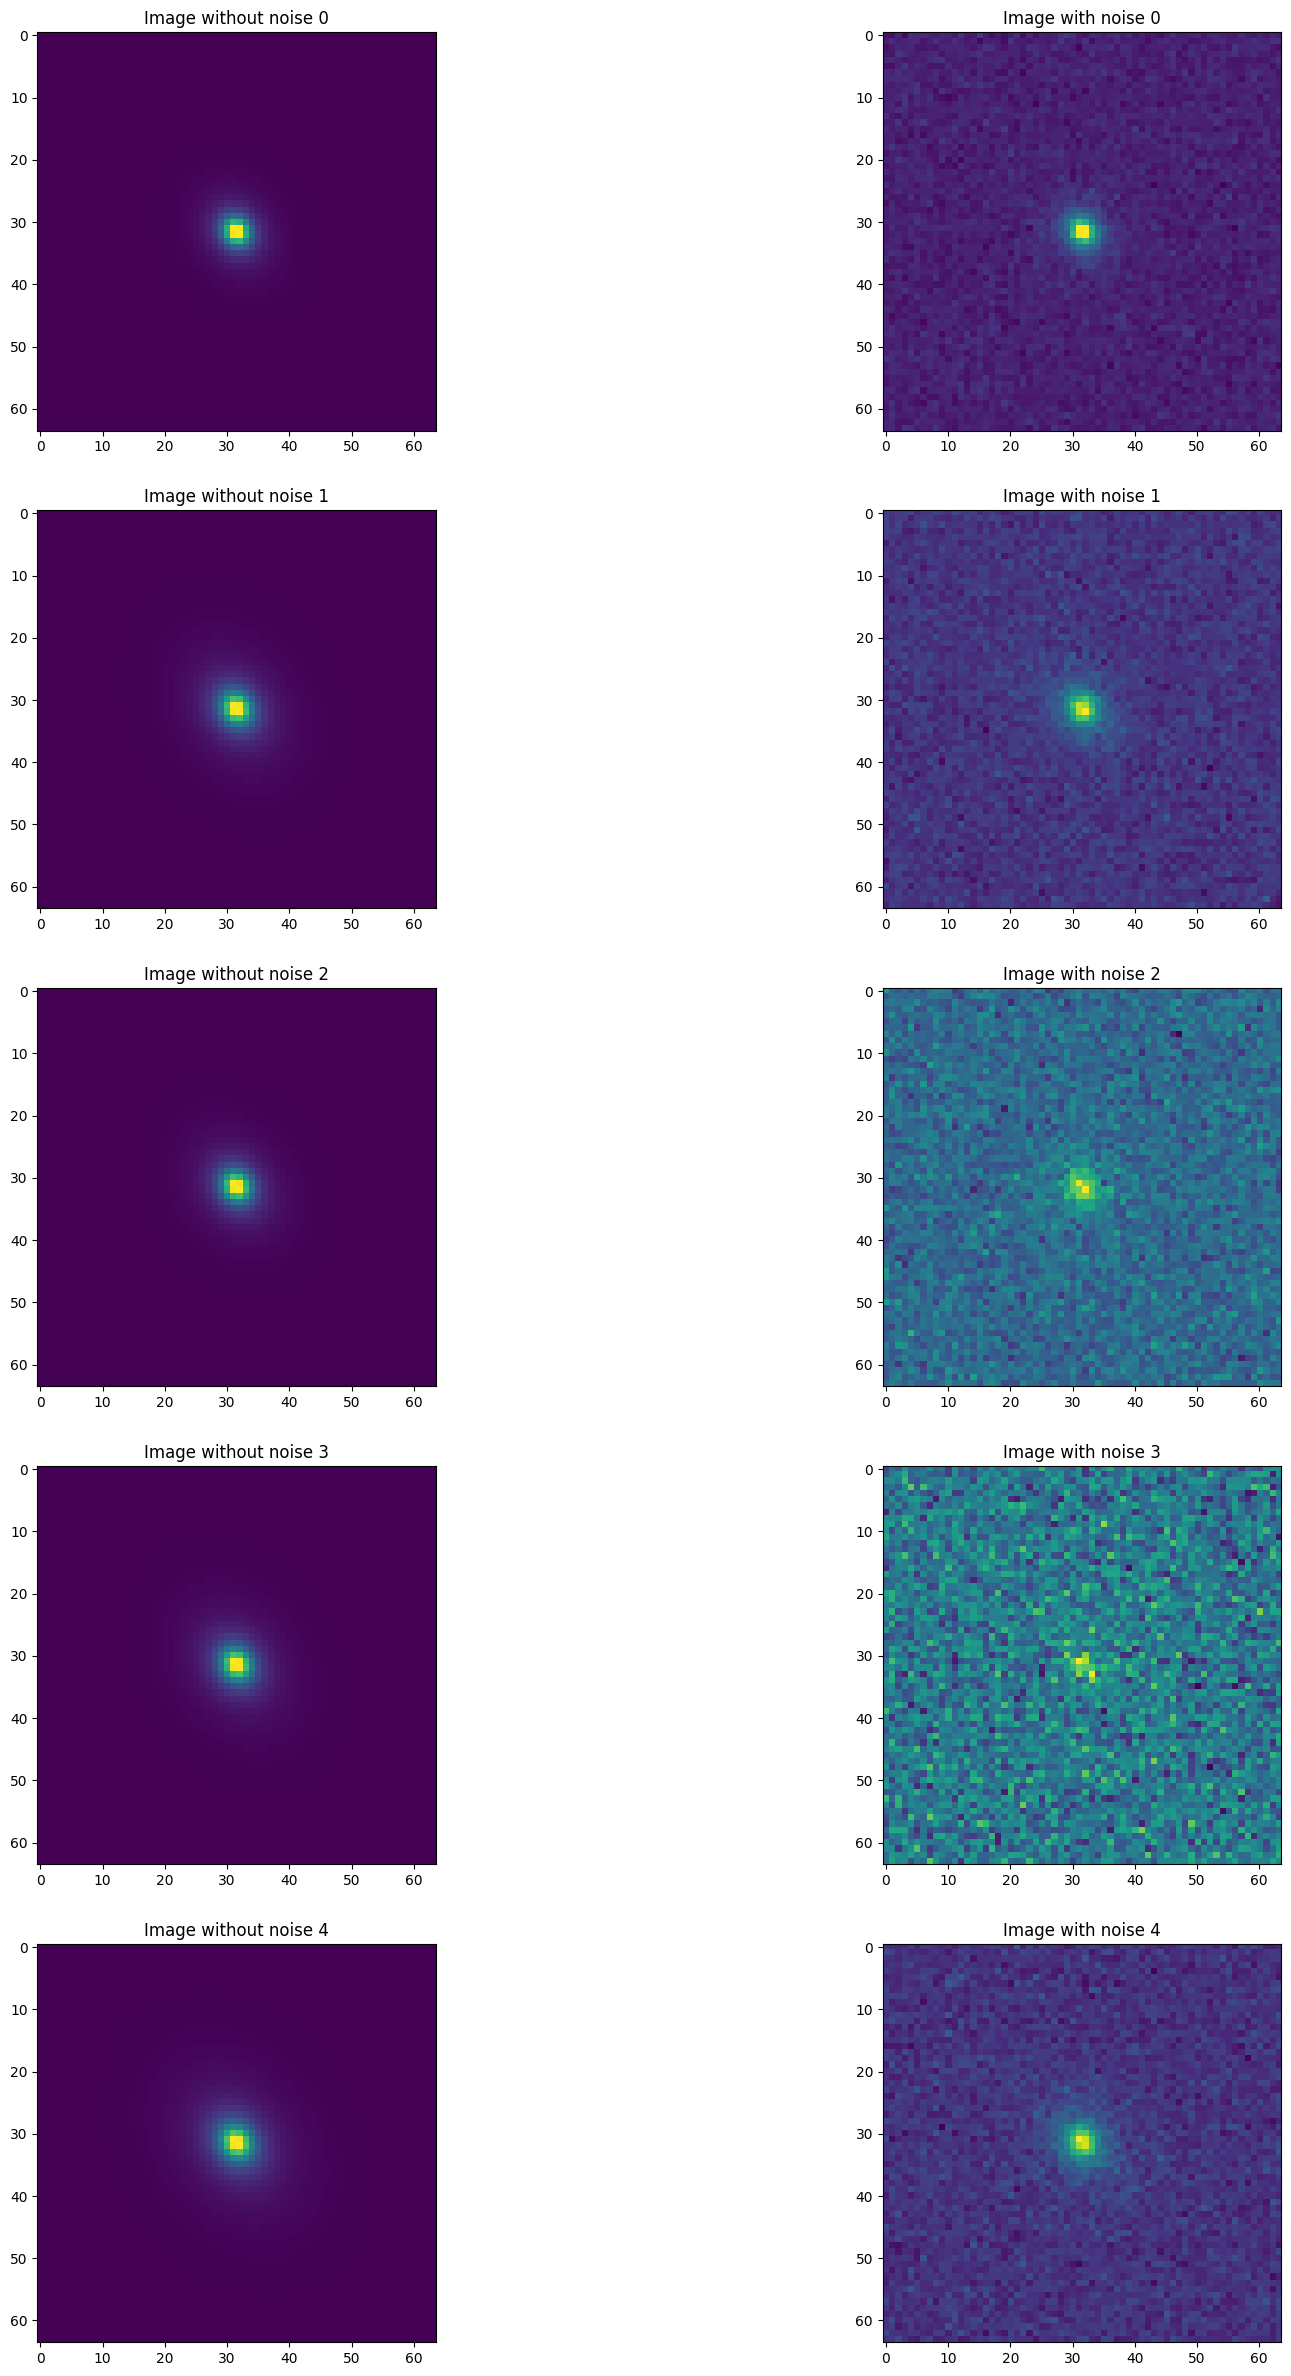

In [10]:
# Plot first five images without noise and with noise
mpl.style.use('default')
fig, ax = plt.subplots(5,2, figsize=(20,30))
for i in range(5):
    ax[i][0].imshow(image_no_noise[i])
    ax[i][0].set_title('Image without noise {}'.format(i))
    ax[i][1].imshow(image_with_noise[i])
    ax[i][1].set_title('Image with noise {}'.format(i))

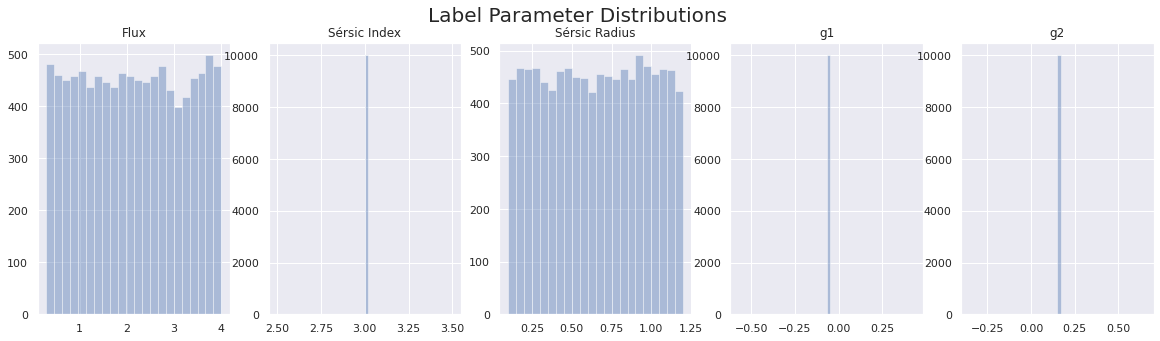

In [17]:
# Plot distributions of label parameters
sns.set()
fig, axes = plt.subplots(1,5, figsize=(20,5));
fig.suptitle('Label Parameter Distributions', fontsize=20)
parameters = ['Flux', 'Sérsic Index', 'Sérsic Radius', 'g1', 'g2']

for i, ax in enumerate(axes.flat):  
  sns.distplot(labels[:, i], kde=False,  ax=ax).set_title(parameters[i]);

In [0]:
# Split data into train and test sets
indices = np.linspace(0, 9999, 10000, dtype = int)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(image_with_noise, labels, indices, 
                                                                                 test_size=0.2, random_state=109)

In [19]:
# Use RidgeCV Model to fit on X_train with cross-validation fold of 5
%%time
clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1], cv=5).fit(X_train.reshape(-1, X_train.shape[1]*X_train.shape[2]), y_train[:, [0,2]])

CPU times: user 3min, sys: 14.4 s, total: 3min 15s
Wall time: 1min 43s


In [20]:
# Print train and test score performance
print(f'Traning Score is: {clf.score(X_train.reshape(-1, X_train.shape[1]*X_train.shape[2]), y_train[:, [0,2]])*100:.2f}')
print(f'Testing Score is: {clf.score(X_test.reshape(-1, X_test.shape[1]*X_test.shape[2]), y_test[:, [0,2]])*100:.2f}')

Traning Score is: 98.48
Testing Score is: 93.60


In [21]:
# Predict on the test set
ridge_pred = clf.predict(X_test.reshape(-1, X_test.shape[1]* X_test.shape[2]))

# Print the r2_score
print(f' R2 Score is: {r2_score(y_test[:, [0,2]], ridge_pred)*100:.2f}')

 R2 Score is: 72.33


Next we plot the predicted values of the parameters (flux and Sérsic radius) against their actual values

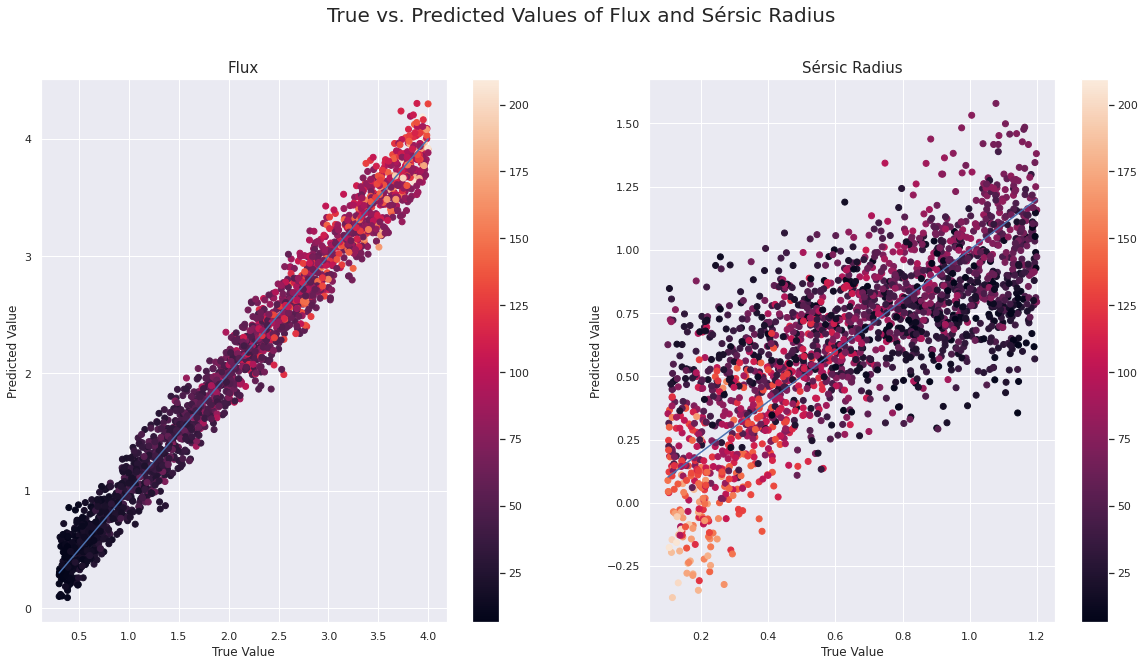

In [23]:
sns.set()
fig, ax = plt.subplots(1,2, figsize=(20,10));
fig.suptitle('True vs. Predicted Values of Flux and Sérsic Radius', fontsize=20)

# Plot true vs. predicted values of flux
im_flux = ax[0].scatter(y_test[:, [0]], ridge_pred[:, 0], c=[snr[indices_test]])
ax[0].set_title('Flux', fontsize=15)
ax[0].set_xlabel('True Value')
ax[0].set_ylabel('Predicted Value')
x = np.linspace(min(y_test[:, [0]]), max(y_test[:, [0]]), 100)
ax[0].plot(x, x)
fig.colorbar(im_flux, ax = ax[0])

# Plot true vs. predicted values of Sérsic radius
im_radius = ax[1].scatter(y_test[:, [2]], ridge_pred[:, 1], c=[snr[indices_test]])
ax[1].set_title('Sérsic Radius', fontsize=15)
ax[1].set_xlabel('True Value')
ax[1].set_ylabel('Predicted Value')
x = np.linspace(min(y_test[:, [2]]), max(y_test[:, [2]]), 100)
ax[1].plot(x, x)
fig.colorbar(im_radius, ax = ax[1]);

## **Convolutional Neural Networks (CNNs)**

We fit our convolutional network to three versions of data that we generated.  The first version is used to predict flux and Sérsic radius with the other parameters held constant (Sérsic index = 3, g1 = -0.0694, g2 = 0.1515) and noise and PSF held constant (300 and 0.5, respectively).  The second version is the same as the first except noise (200,400) and PSF (0.5, 1) are allowed to vary.  The third version is used to predict all the labels, but noise and PSF are held constant again.

In [0]:
# Import relevant libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers, optimizers

In [0]:
# Reshape data
X_train = X_train.reshape((X_train.shape[0], 64, 64, 1))
X_test = X_test.reshape((X_test.shape[0], 64, 64, 1))

Below is the model architecture for the CNNs we will make.

In [0]:
# Function to create CNN
def create_model(num_param): 
    
    # Create sequential model
    model = Sequential(name='CNN_Model') 

    # Add network layers
    model.add(Conv2D(32, (3, 3), padding = 'same', activation='relu',  input_shape=(64, 64, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), padding = 'same', activation='relu')) 
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), padding = 'same', strides = (2,2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), padding = 'same', activation='relu')) 
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding = 'same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding = 'same', activation='relu')) 
    model.add(BatchNormalization())
    model.add(Conv2D(1, (3, 3), padding = 'same', strides = (2,2), activation='relu'))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01),))
    model.add(Dense(num_param, activation='linear'))

    model.summary()
    
    return model

### CNN #1: Predicting flux and Sérsic radius with the other parameters, noise, and PSF held constant.


In [27]:
# Create model
CNN = create_model(num_param=2)

Model: "CNN_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 128)       36992     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 256)       295168    
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 256)       1024      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 512)       11

In [0]:
# Define optimizer
optimizer = optimizers.Adam(lr=0.0001, clipvalue=0.5)

# Define callbacks
callbacks = [ 
            tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            verbose=1)]

# Compile model
CNN.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_absolute_error'])

In [29]:
# Set hyperparameters
batch_size = 32
epochs = 100

# Train model
history = CNN.fit(X_train, y_train[:, [0,2]], batch_size=batch_size, epochs=epochs, 
                    validation_data=(X_test, y_test[:, [0,2]]), shuffle=True, verbose=1, callbacks=callbacks)

Epoch 1/100
250/250 [==============================] - 40s 160ms/step - loss: 1.7137 - mean_absolute_error: 0.2212 - val_loss: 1.4553 - val_mean_absolute_error: 0.1857
Epoch 2/100
250/250 [==============================] - 39s 158ms/step - loss: 1.2128 - mean_absolute_error: 0.1248 - val_loss: 1.0588 - val_mean_absolute_error: 0.1318
Epoch 3/100
250/250 [==============================] - 41s 164ms/step - loss: 0.9182 - mean_absolute_error: 0.1151 - val_loss: 0.8002 - val_mean_absolute_error: 0.1067
Epoch 4/100
250/250 [==============================] - 42s 169ms/step - loss: 0.7158 - mean_absolute_error: 0.1060 - val_loss: 0.6982 - val_mean_absolute_error: 0.1628
Epoch 5/100
250/250 [==============================] - 42s 168ms/step - loss: 0.5774 - mean_absolute_error: 0.0994 - val_loss: 0.5305 - val_mean_absolute_error: 0.1036
Epoch 6/100
250/250 [==============================] - 42s 168ms/step - loss: 0.4883 - mean_absolute_error: 0.1016 - val_loss: 0.5338 - val_mean_absolute_error:

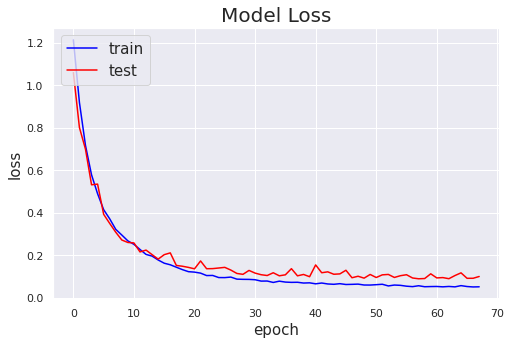

In [30]:
# Plot model loss trend
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'][1:], c='blue')
plt.plot(history.history['val_loss'][1:], c='red')
plt.title('Model Loss', fontsize=20)
plt.ylabel('loss', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend(['train', 'test'], loc='upper left', fontsize=15);


Next we plot the predicted values of the parameters (flux and Sérsic radius) against their actual values.




In [0]:
# Generate predictions using test data
CNN_predictions = CNN.predict(X_test)

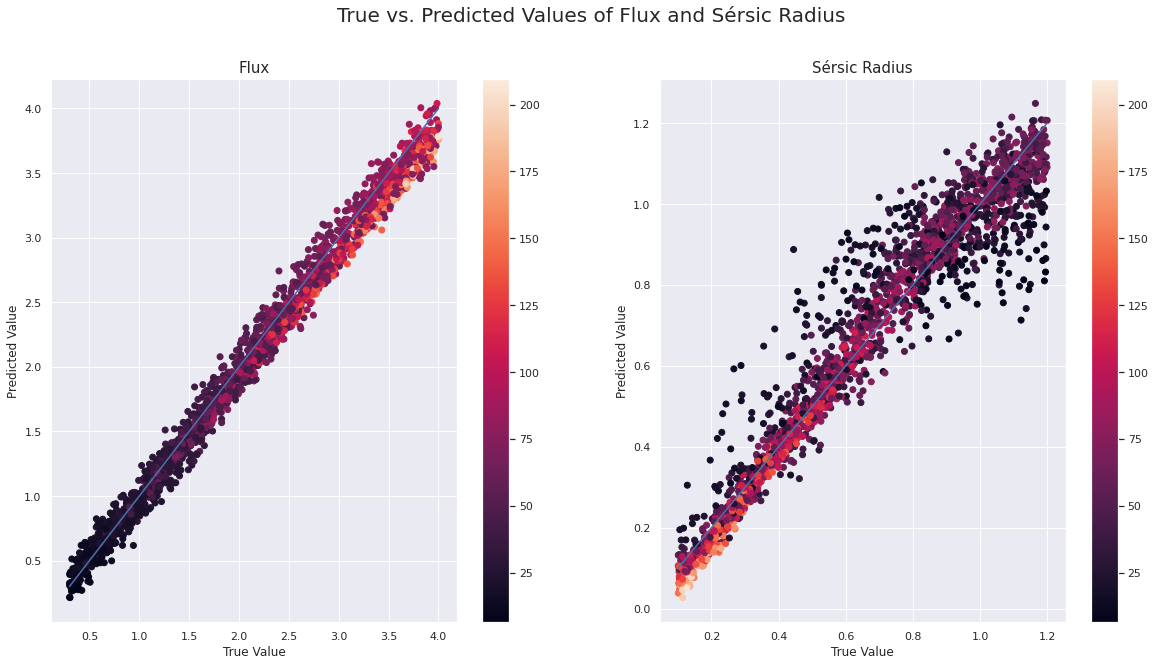

In [33]:
sns.set()
fig, ax = plt.subplots(1,2, figsize=(20,10));
fig.suptitle('True vs. Predicted Values of Flux and Sérsic Radius', fontsize=20)

# Plot true vs. predicted values of flux
im_flux = ax[0].scatter(y_test[:, [0]], CNN_predictions[:, 0], c=[snr[indices_test]])
ax[0].set_title('Flux', fontsize=15)
ax[0].set_xlabel('True Value')
ax[0].set_ylabel('Predicted Value')
x = np.linspace(min(y_test[:, [0]]), max(y_test[:, [0]]), 100)
ax[0].plot(x, x)
fig.colorbar(im_flux, ax = ax[0])

# Plot true vs. predicted values of Sérsic radius
im_radius = ax[1].scatter(y_test[:, [2]], CNN_predictions[:, 1], c=[snr[indices_test]])
ax[1].set_title('Sérsic Radius', fontsize=15)
ax[1].set_xlabel('True Value')
ax[1].set_ylabel('Predicted Value')
x = np.linspace(min(y_test[:, [2]]), max(y_test[:, [2]]), 100)
ax[1].plot(x, x)
fig.colorbar(im_radius, ax = ax[1]);

**Prediction Errors**

We use two methods to examine prediction errors.  First we pull predicted images with SNR around 30 and 60  (less than 31 and greater than 29, less than 61 and greater than 59).  We then examine the difference between the predicted and true images.  



The error for flux for images of SNR 60 is lower than the error for flux for images of SNR 30 as expected, but sersic radius error is greater for images of SNR 60. 

**Second Method**

Our second method for examining prediction error consists of generating a dataset of images of SNR 30 and 60 according to the parameters in the CRB table (flux = 100,000, Sersic Index = 3, Sersic Radius = 0.3, G1 = -0.069, G2 = 0.15).  Noise of 399 was used to get SNR 30 and noise of 199 used to get SNR of 60. 

In [34]:
# Set file path to access images
file_path = '/content/drive/My Drive/Data/Target Images (for prediction error)'
os.chdir(file_path)
print('Working Directory:',os.getcwd())

Working Directory: /content/drive/My Drive/Data/Target Images (for prediction error)


In [0]:
# Load images
target_with_noise_img_30 = pd.read_pickle('img_with_noise_target_30.pkl')
target_with_noise_img_60 = pd.read_pickle('img_with_noise_target_60.pkl')
target_labels = pd.read_pickle('labels_target.pkl')

In [0]:
# Function to get prediction error
def get_errors(image_set, target_labels, model, num_param):

  # Expand dimensions
  target_img = np.expand_dims(image_set, axis=3)

  # Predict using CNN
  target_predictions = model.predict(target_img)
  
  if num_param == 2:

    # Calculate errors
    errors = target_predictions - target_labels[:, [0, 2]]
    
    # Calculate the mean and standard deviation of errors
    flux_error = errors[:, 0].mean()
    radius_error = errors[:, 1].mean()
    flux_std = np.std(errors[:, 0])
    radius_std = np.std(errors[:, 1])

    return flux_error, radius_error, flux_std, radius_std

  else:

    # Calculate errors
    errors = target_predictions - target_labels

    # Calculate mean and standard deviation of errors
    flux_error = errors[:, 0].mean()
    index_error = errors[:, 1].mean()
    radius_error = errors[:, 2].mean()
    g1_error = errors[:, 3].mean()
    g2_error = errors[:, 4].mean()
    flux_std = np.std(errors[:, 0])
    index_std = np.std(errors[:, 1])
    radius_std = np.std(errors[:, 2])
    g1_std = np.std(errors[:, 3])
    g2_std = np.std(errors[:, 4])

    return flux_error, index_error, radius_error, g1_error, g2_error, flux_std, index_std, radius_std, g1_std, g2_std

In [74]:
flux_error_30, radius_error_30, flux_std_30, radius_std_30 = get_errors(target_with_noise_img_30, target_labels, CNN, 2)
flux_error_60, radius_error_60, flux_std_60, radius_std_60 = get_errors(target_with_noise_img_60, target_labels, CNN, 2)

print("Flux error 30: %s +/- %s" %(round(flux_error_30,3), round(flux_std_30, 2)))
print("Sersic Radius error 30: %s +/- %s" %(round(radius_error_30,3), round(radius_std_30, 2)))
print("\nFlux error 60: %s +/- %s" %(round(flux_error_60,3), round(flux_std_60, 2)))
print("Sersic Radius error 60: %s +/- %s" %(round(radius_error_60,3), round(radius_std_60, 2)))

Flux error 30: -0.084 +/- 0.07
Sersic Radius error 30: -0.021 +/- 0.05

Flux error 60: 0.019 +/- 0.05
Sersic Radius error 60: -0.006 +/- 0.03


### CNN #2: Predicting flux and Sérsic radius with the other parameters held constant, and noise and PSF varying for each image


In [43]:
# Set new file path to access generated dataset
file_path = '/content/drive/My Drive/Data/Data_flux_radius_noisy'
os.chdir(file_path)
print('Working Directory:',os.getcwd())

# Load generated dataset
image_no_noise_v = pd.read_pickle('img_no_noise_flux_radius_noise.pkl')
image_with_noise_v = pd.read_pickle('img_with_flux_radius_noise.pkl')
labels_v = pd.read_pickle('labels_flux_radius_noise.pkl')
snr_v = pd.read_pickle('snr_flux_radius_noise.pkl')

Working Directory: /content/drive/My Drive/Data/Data_flux_radius_noisy


In [0]:
# Split data into train and test sets
indices = np.linspace(0, 9999, 10000, dtype = int)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(image_with_noise_v, labels_v, indices, test_size=0.2, random_state=109)

# Reshape data
X_train = X_train.reshape((X_train.shape[0], 64, 64, 1))
X_test = X_test.reshape((X_test.shape[0], 64, 64, 1))

In [48]:
# Create model
CNN_2 = create_model(num_param=2)

# Define optimizer
optimizer = optimizers.Adam(lr=0.0001, clipvalue=0.5)

# Define callbacks
callbacks = [ 
            tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            verbose=1)]

# Compile model
CNN_2.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_absolute_error'])

Model: "CNN_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
batch_normalization_8 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 128)       36992     
_________________________________________________________________
batch_normalization_9 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 256)       295168    
_________________________________________________________________
batch_normalization_10 (Batc (None, 64, 64, 256)       1024      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 512)       11

In [49]:
# Set hyperparameters
batch_size = 32
epochs = 100

# Train model
history = CNN_2.fit(X_train, y_train[:, [0,2]], batch_size=batch_size, epochs=epochs, 
                    validation_data=(X_test, y_test[:, [0,2]]), shuffle=True, verbose=1, callbacks=callbacks)

Epoch 1/100
250/250 [==============================] - 43s 173ms/step - loss: 1.7181 - mean_absolute_error: 0.2352 - val_loss: 1.6493 - val_mean_absolute_error: 0.3840
Epoch 2/100
250/250 [==============================] - 42s 167ms/step - loss: 1.2555 - mean_absolute_error: 0.1649 - val_loss: 1.1344 - val_mean_absolute_error: 0.1987
Epoch 3/100
250/250 [==============================] - 42s 170ms/step - loss: 0.9549 - mean_absolute_error: 0.1384 - val_loss: 0.8662 - val_mean_absolute_error: 0.1555
Epoch 4/100
250/250 [==============================] - 42s 170ms/step - loss: 0.7614 - mean_absolute_error: 0.1314 - val_loss: 0.8728 - val_mean_absolute_error: 0.3143
Epoch 5/100
250/250 [==============================] - 42s 169ms/step - loss: 0.6217 - mean_absolute_error: 0.1184 - val_loss: 0.5841 - val_mean_absolute_error: 0.1302
Epoch 6/100
250/250 [==============================] - 42s 169ms/step - loss: 0.5254 - mean_absolute_error: 0.1105 - val_loss: 0.5262 - val_mean_absolute_error:

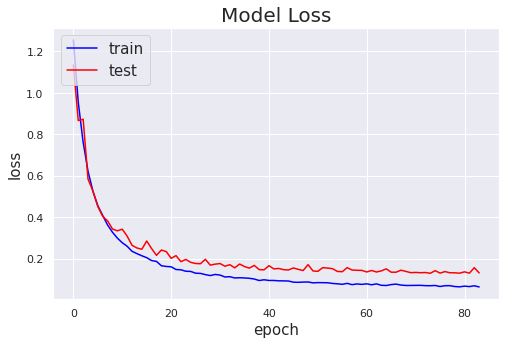

In [50]:
# Plot model loss trend
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'][1:], c='blue')
plt.plot(history.history['val_loss'][1:], c='red')
plt.title('Model Loss', fontsize=20)
plt.ylabel('loss', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend(['train', 'test'], loc='upper left', fontsize=15);

Next we plot the predicted values of the parameters (flux and Sérsic radius) against their actual values.

In [0]:
# Generate predictions on test set
CNN_predictions = CNN_2.predict(X_test)

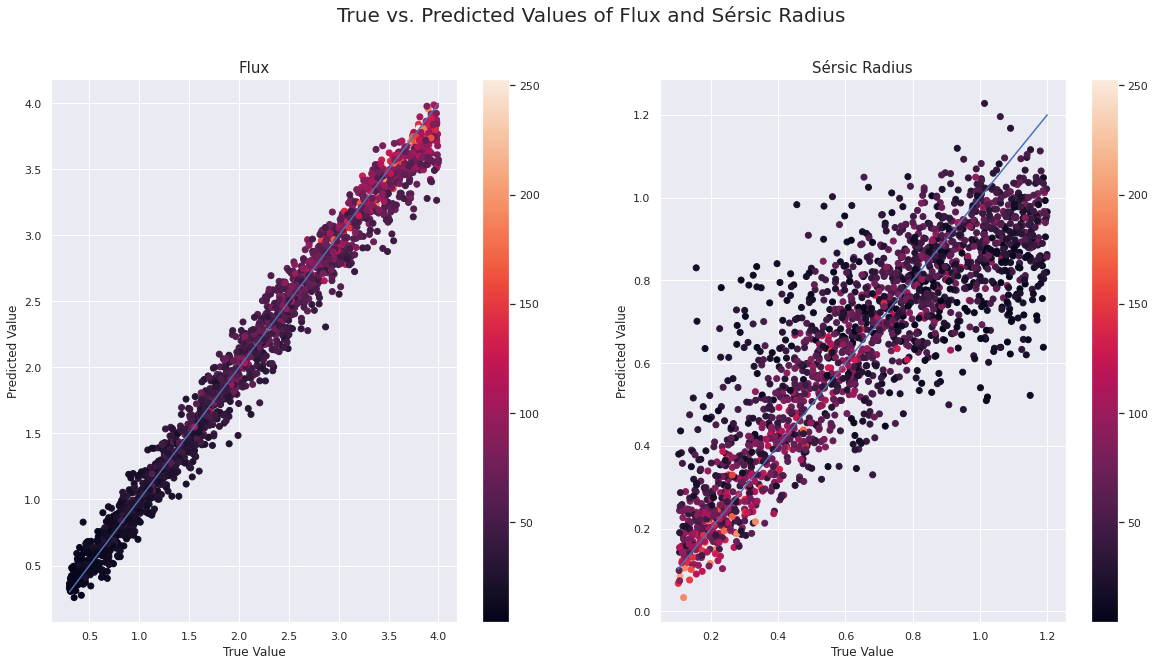

In [56]:
fig, ax = plt.subplots(1,2, figsize=(20,10));
fig.suptitle('True vs. Predicted Values of Flux and Sérsic Radius', fontsize=20)

# Plot true vs. predicted values of flux
im_flux = ax[0].scatter(y_test[:, [0]], CNN_predictions[:, 0], c=[snr_v[indices_test]])
ax[0].set_title('Flux', fontsize=15)
ax[0].set_xlabel('True Value')
ax[0].set_ylabel('Predicted Value')
x = np.linspace(min(y_test[:, [0]]), max(y_test[:, [0]]), 100)
ax[0].plot(x, x)
fig.colorbar(im_flux, ax = ax[0])

# Plot true vs. predicted values of Sérsic radius
im_radius = ax[1].scatter(y_test[:, [2]], CNN_predictions[:, 1], c=[snr_v[indices_test]])
ax[1].set_title('Sérsic Radius', fontsize=15)
ax[1].set_xlabel('True Value')
ax[1].set_ylabel('Predicted Value')
x = np.linspace(min(y_test[:, [2]]), max(y_test[:, [2]]), 100)
ax[1].plot(x, x)
fig.colorbar(im_radius, ax = ax[1]);

Prediction errors

In [69]:
flux_error_30, radius_error_30, flux_std_30, radius_std_30 = get_errors(target_with_noise_img_30, target_labels, CNN_2, 2)
flux_error_60, radius_error_60, flux_std_60, radius_std_60 = get_errors(target_with_noise_img_60, target_labels, CNN_2, 2)

print("Flux error 30: %s +/- %s" %(round(flux_error_30, 3), round(flux_std_30, 2)))
print("Sersic Radius error 30: %s +/- %s" %(round(radius_error_30, 3), round(radius_std_30, 2)))
print("\nFlux error 60: %s +/- %s" %(round(flux_error_60, 3), round(flux_std_60, 2)))
print("Sersic Radius error 60: %s +/- %s" %(round(radius_error_60, 3), round(radius_std_60, 2)))

Flux error 30: 0.005 +/- 0.08
Sersic Radius error 30: -0.013 +/- 0.07

Flux error 60: -0.006 +/- 0.05
Sersic Radius error 60: -0.087 +/- 0.04


### CNN #3: Predicting all parameters with noise and PSF fixed

In [57]:
# Set new file path to access generated dataset
file_path = '/content/drive/My Drive/Data/Data_all_fixed_noise'
os.chdir(file_path)
print('Working Directory:',os.getcwd())

# Load generated dataset
image_no_noise_all= pd.read_pickle('img_no_noise_all.pkl')
image_with_noise_all= pd.read_pickle('img_with_noise_all.pkl')
labels_all = pd.read_pickle('labels_all.pkl')
snr_all = pd.read_pickle('snr_all.pkl')

Working Directory: /content/drive/My Drive/Data/Data_all_fixed_noise


In [0]:
# Split data into train and test sets
indices = np.linspace(0, 9999, 10000, dtype = int)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(image_with_noise_all, labels_all, indices, test_size=0.2, random_state=109)

# Reshape data
X_train = X_train.reshape((X_train.shape[0], 64, 64, 1))
X_test = X_test.reshape((X_test.shape[0], 64, 64, 1))

In [61]:
# Create model
CNN_all = create_model(5)

# Define optimizer
optimizer = optimizers.Adam(lr=0.0001, clipvalue=0.5)

# Define callbacks
callbacks = [ 
            tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            verbose=1)]

# Compile model
CNN_all.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_absolute_error'])

Model: "CNN_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
batch_normalization_16 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 128)       36992     
_________________________________________________________________
batch_normalization_17 (Batc (None, 64, 64, 128)       512       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 64, 64, 256)       295168    
_________________________________________________________________
batch_normalization_18 (Batc (None, 64, 64, 256)       1024      
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 512)       11

In [62]:
# Set hyperparameters
batch_size = 32
epochs = 100

# Train model
history = CNN_all.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_data=(X_test, y_test), shuffle=True, verbose=1, callbacks=callbacks)

Epoch 1/100
250/250 [==============================] - 43s 173ms/step - loss: 1.8305 - mean_absolute_error: 0.4061 - val_loss: 1.4499 - val_mean_absolute_error: 0.3026
Epoch 2/100
250/250 [==============================] - 42s 167ms/step - loss: 1.1881 - mean_absolute_error: 0.2467 - val_loss: 0.9904 - val_mean_absolute_error: 0.2266
Epoch 3/100
250/250 [==============================] - 42s 169ms/step - loss: 0.8518 - mean_absolute_error: 0.2165 - val_loss: 0.7378 - val_mean_absolute_error: 0.2138
Epoch 4/100
250/250 [==============================] - 42s 169ms/step - loss: 0.6342 - mean_absolute_error: 0.1920 - val_loss: 0.5793 - val_mean_absolute_error: 0.2080
Epoch 5/100
250/250 [==============================] - 42s 169ms/step - loss: 0.4983 - mean_absolute_error: 0.1793 - val_loss: 0.5527 - val_mean_absolute_error: 0.2794
Epoch 6/100
250/250 [==============================] - 42s 169ms/step - loss: 0.4007 - mean_absolute_error: 0.1614 - val_loss: 0.4128 - val_mean_absolute_error:

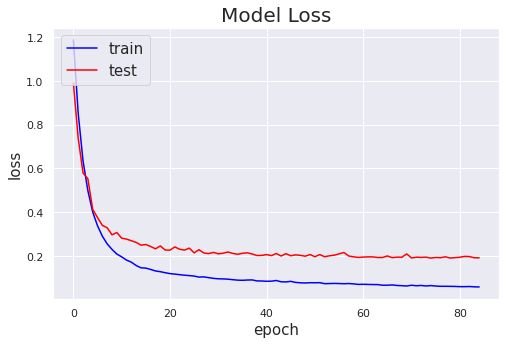

In [63]:
# Plot model loss trend
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'][1:], c='blue')
plt.plot(history.history['val_loss'][1:], c='red')
plt.title('Model Loss', fontsize=20)
plt.ylabel('loss', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend(['train', 'test'], loc='upper left', fontsize=15);

In [0]:
# Generate predictions on test data
CNN_predictions_all = CNN_all.predict(X_test)

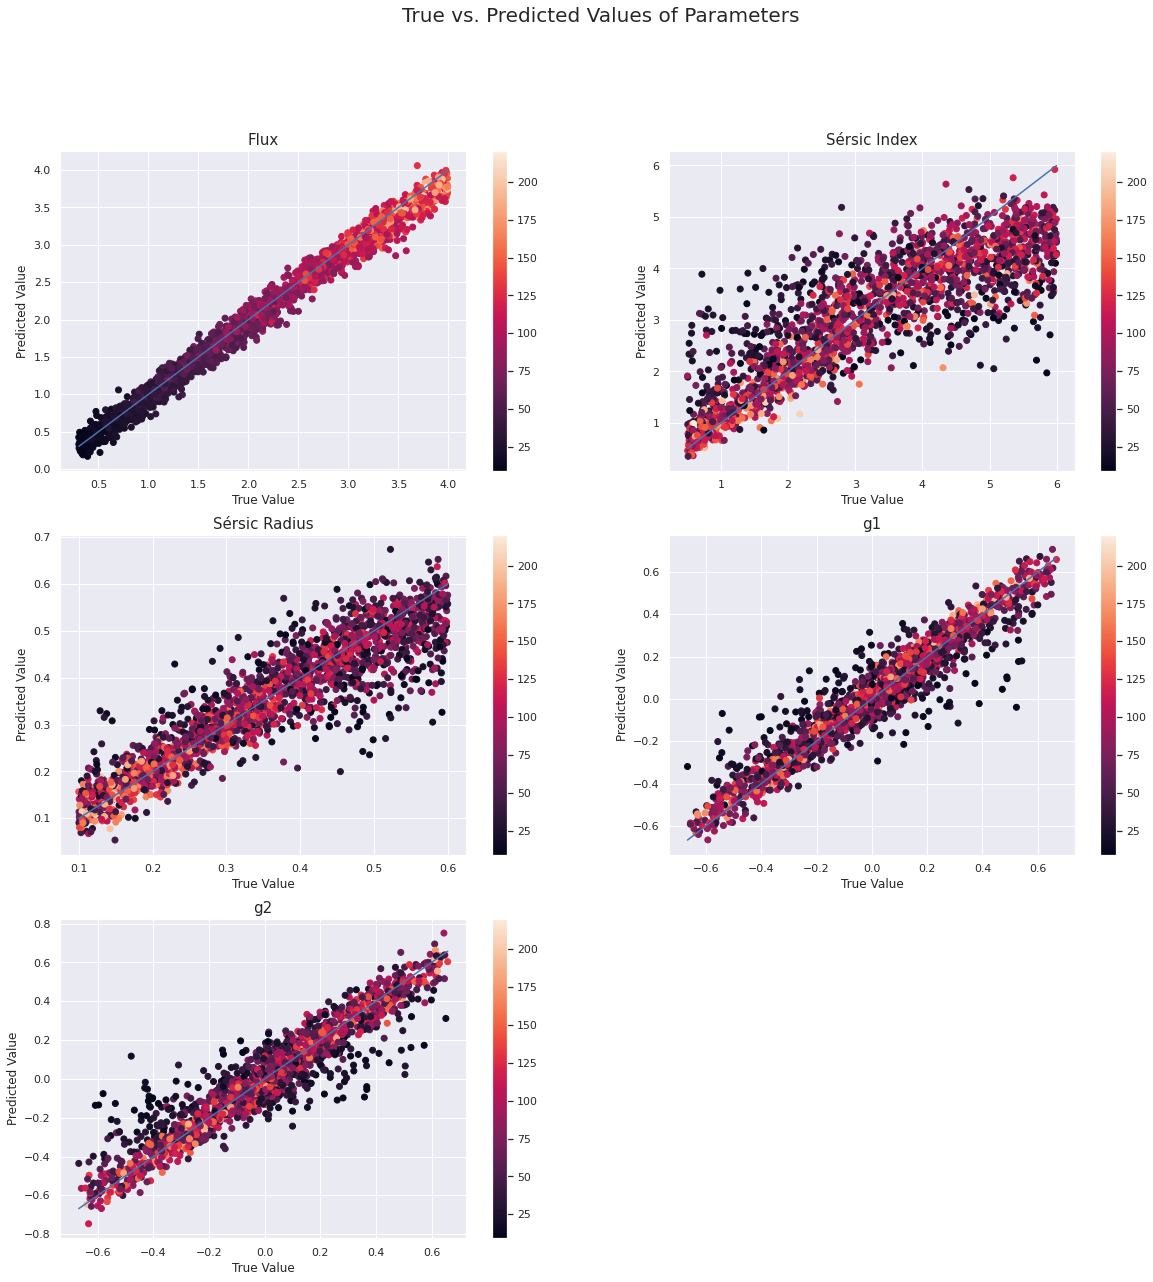

In [65]:
# Plot true vs. predicted values of all parameters
fig, axes = plt.subplots(3,2, figsize=(20,20))
fig.delaxes(axes[2,1])
parameters = ['Flux', 'Sérsic Index', 'Sérsic Radius', 'g1', 'g2']

for i in range(5):

  im_var = axes.flat[i].scatter(y_test[:, i], CNN_predictions_all[:, i], c=[snr_all[indices_test]])
  x = np.linspace(min(y_test[:, [i]]), max(y_test[:, [i]]), 100)
  axes.flat[i].plot(x, x)
  fig.colorbar(im_var, ax=axes.flat[i])

  axes.flat[i].set_xlabel('True Value')
  axes.flat[i].set_ylabel('Predicted Value')
  axes.flat[i].set_title(parameters[i], fontsize=15)

fig.suptitle('True vs. Predicted Values of Parameters', fontsize=20);

In [75]:
# Get prediction errors for images with SNR=30 and SNR=60
flux_error_30, index_error_30, radius_error_30, g1_error_30, g2_error_30, flux_std_30, index_std_30, radius_std_30, g1_std_30, g2_std_30 = get_errors(target_with_noise_img_30, target_labels, CNN_all, 5)
flux_error_60, index_error_60, radius_error_60, g1_error_60, g2_error_60, flux_std_60, index_std_60, radius_std_60, g1_std_60, g2_std_60 = get_errors(target_with_noise_img_60, target_labels, CNN_all, 5)

print("Flux error 30: %s +/- %s" %(round(flux_error_30,3), round(flux_std_30, 2)))
print("Sersic Index error 30: %s +/- %s" %(round(index_error_30,3), round(index_std_30, 2)))
print("Sersic Radius error 30: %s +/- %s" %(round(radius_error_30,3), round(radius_std_30, 2)))
print("G1 error 30: %s +/- %s" %(round(g1_error_30,3), round(g1_std_30, 2)))
print("G2 error 30: %s +/- %s" %(round(g2_error_30,3), round(g2_std_30, 2)))
print("\nFlux error 60: %s +/- %s" %(round(flux_error_60,3), round(flux_std_60, 2)))
print("Sersic Index error 60: %s +/- %s" %(round(index_error_60,3), round(index_std_60, 2)))
print("Sersic Radius error 60: %s +/- %s" %(round(radius_error_60,3), round(radius_std_60, 2)))
print("G1 error 60: %s +/- %s" %(round(g1_error_60,3), round(g1_std_60, 2)))
print("G2 error 60: %s +/- %s" %(round(g2_error_60,3), round(g2_std_60, 2)))

Flux error 30: -0.081 +/- 0.09
Sersic Index error 30: 0.203 +/- 0.72
Sersic Radius error 30: -0.015 +/- 0.06
G1 error 30: 0.019 +/- 0.11
G2 error 30: -0.026 +/- 0.1

Flux error 60: 0.107 +/- 0.06
Sersic Index error 60: 1.006 +/- 0.48
Sersic Radius error 60: 0.046 +/- 0.04
G1 error 60: -0.006 +/- 0.07
G2 error 60: -0.0 +/- 0.06


### CNN #4: Predicting all parameters using the dataset provided (noise and PSF not fixed)


In [76]:
# Set new file path to access provided dataset
file_path = '/content/drive/My Drive/Data'
os.chdir(file_path)
print('Working Directory:',os.getcwd())

# Load provided dataset
f=h5py.File('Data.h5','r')
image = f['img'][:]    
cat = f['cat'][:]  
label = f['label'][:]   # Parameters
snr = f['snr'][:]
sigma = f['sigma'][:]
image_nonoise = f['img_nonoise'][:]    
image_withnoise = f['img_withnoise'][:]    
f.close()

Working Directory: /content/drive/My Drive/Data


In [0]:
# Split data into train and test sets
indices = np.linspace(0, 18778, 18779, dtype = int)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(image_withnoise, label, indices, test_size=0.2, random_state=109)

# Reshape data
X_train = X_train.reshape((X_train.shape[0], 64, 64, 1))
X_test = X_test.reshape((X_test.shape[0], 64, 64, 1))

In [78]:
# Create model
CNN_all_provided = create_model(5)

# Define optimizer
optimizer = optimizers.Adam(lr=0.0001, clipvalue=0.5)

# Define callbacks
callbacks = [ 
            tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            verbose=1)]

# Compile model
CNN_all_provided.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['mean_absolute_error'])

Model: "CNN_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 64, 64, 32)        320       
_________________________________________________________________
batch_normalization_24 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 64, 64, 128)       36992     
_________________________________________________________________
batch_normalization_25 (Batc (None, 64, 64, 128)       512       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 64, 64, 256)       295168    
_________________________________________________________________
batch_normalization_26 (Batc (None, 64, 64, 256)       1024      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 32, 32, 512)       11

In [0]:
# Set hyperparameters
batch_size = 32
epochs = 50

# Train model
history = CNN_all_provided.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_data=(X_test, y_test), shuffle=True, verbose=1, callbacks=callbacks)

Epoch 1/50
470/470 [==============================] - 75s 159ms/step - loss: 1.6848 - mean_absolute_error: 0.4146 - val_loss: 1.1963 - val_mean_absolute_error: 0.3197
Epoch 2/50
470/470 [==============================] - 74s 158ms/step - loss: 0.9452 - mean_absolute_error: 0.3104 - val_loss: 0.7450 - val_mean_absolute_error: 0.2973
Epoch 3/50
470/470 [==============================] - 75s 160ms/step - loss: 0.6279 - mean_absolute_error: 0.2887 - val_loss: 0.5433 - val_mean_absolute_error: 0.2879
Epoch 4/50
470/470 [==============================] - 75s 159ms/step - loss: 0.4784 - mean_absolute_error: 0.2728 - val_loss: 0.5130 - val_mean_absolute_error: 0.3469
Epoch 5/50
470/470 [==============================] - 75s 160ms/step - loss: 0.3916 - mean_absolute_error: 0.2508 - val_loss: 0.4211 - val_mean_absolute_error: 0.3014
Epoch 6/50
470/470 [==============================] - 75s 160ms/step - loss: 0.3320 - mean_absolute_error: 0.2269 - val_loss: 0.3871 - val_mean_absolute_error: 0.294

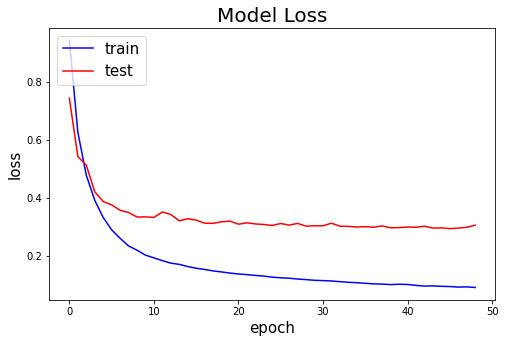

In [0]:
# Plot model loss trend
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'][1:], c='blue')
plt.plot(history.history['val_loss'][1:], c='red')
plt.title('Model Loss', fontsize=20)
plt.ylabel('loss', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend(['train', 'test'], loc='upper left', fontsize=15);

In [0]:
# Generate predictions on test data
CNN_predictions_all = CNN_all_provided.predict(X_test)

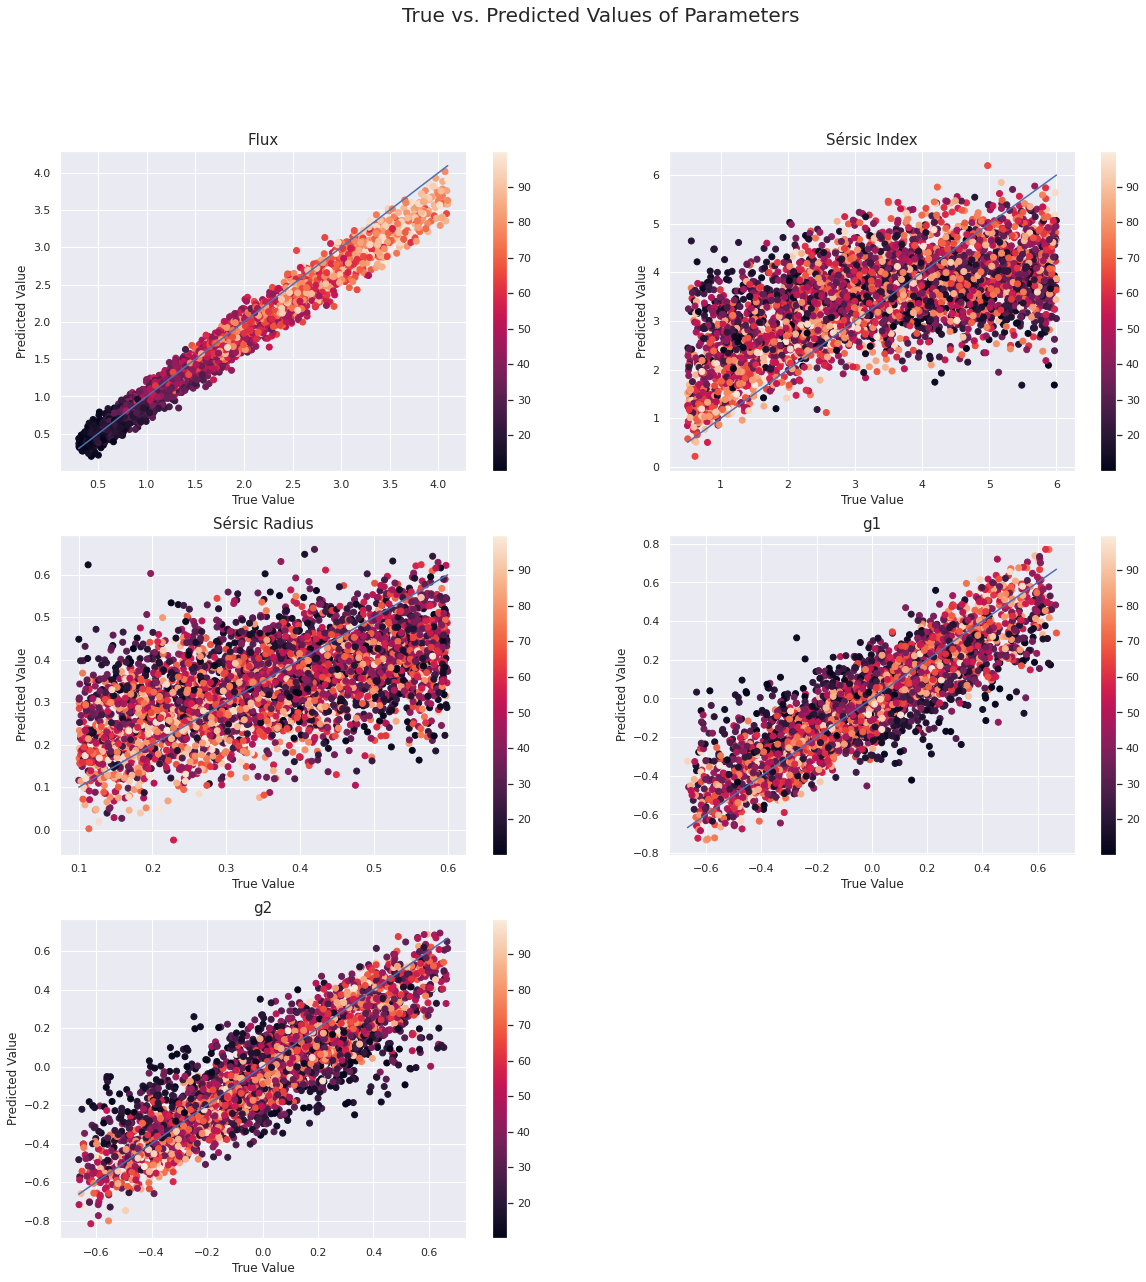

In [0]:
# Plot true vs. predicted values of each of the parameters
fig, axes = plt.subplots(3,2, figsize=(20,20))
fig.delaxes(axes[2,1])
parameters = ['Flux', 'Sérsic Index', 'Sérsic Radius', 'g1', 'g2']

for i in range(5):

  im_var = axes.flat[i].scatter(y_test[:, i], CNN_predictions_all[:, i], c=[snr[indices_test]])
  x = np.linspace(min(y_test[:, [i]]), max(y_test[:, [i]]), 100)
  axes.flat[i].plot(x, x)
  fig.colorbar(im_var, ax=axes.flat[i])

  axes.flat[i].set_xlabel('True Value')
  axes.flat[i].set_ylabel('Predicted Value')
  axes.flat[i].set_title(parameters[i], fontsize=15)

fig.suptitle('True vs. Predicted Values of Parameters', fontsize=20);

In [0]:
file_path = '/content/drive/My Drive/Data/Target Images (for prediction error)'
os.chdir(file_path)
print('Working Directory:',os.getcwd())

#target_with_noise_img_30 = pd.read_pickle('img_with_noise_target_30.pkl')
#target_with_noise_img_60 = pd.read_pickle('img_with_noise_target_60.pkl')
#target_labels = pd.read_pickle('labels_target.pkl')

target_img_30 = np.expand_dims(target_with_noise_img_30, axis=3)
target_img_60 = np.expand_dims(target_with_noise_img_60, axis=3)

target_predictions_30 = CNN_predictions_all.predict(target_img_30)
target_predictions_60 = CNN_predictions_all.predict(target_img_60)


errors_30 = target_predictions_30 - target_labels
errors_60 = target_predictions_60 - target_labels

flux_error_30 = errors_30[:, 0].mean()
index_error_30 = errors_30[:, 1].mean()
radius_error_30 = errors_30[:, 2].mean()
g1_error_30 = errors_30[:, 3].mean()
g2_error_30 = errors_30[:, 4].mean()
flux_std_30 = np.std(errors_30[:, 0])
index_std_30 = np.std(errors_30[:, 1])
radius_std_30 = np.std(errors_30[:, 2])
g1_std_30 = np.std(errors_30[:, 3])
g2_std_30 = np.std(errors_30[:, 4])


print("Flux error 30: %s +/- %s" %(round(flux_error_30,3), round(flux_std_30, 2)))
print("Sersic Index error 30: %s +/- %s" %(round(index_error_30,3), round(index_std_30, 2)))
print("Sersic Radius error 30: %s +/- %s" %(round(radius_error_30,3), round(radius_std_30, 2)))
print("G1 error 30: %s +/- %s" %(round(g1_error_30,3), round(g1_std_30, 2)))
print("G2 error 30: %s +/- %s" %(round(g2_error_30,3), round(g2_std_30, 2)))


flux_error_60 = errors_60[:, 0].mean()
index_error_60 = errors_60[:, 1].mean()
radius_error_60 = errors_60[:, 2].mean()
g1_error_60 = errors_60[:, 3].mean()
g2_error_60 = errors_60[:, 4].mean()
flux_std_60 = np.std(errors_60[:, 0])
index_std_60 = np.std(errors_60[:, 1])
radius_std_60 = np.std(errors_60[:, 2])
g1_std_60 = np.std(errors_60[:, 3])
g2_std_60 = np.std(errors_60[:, 4])


print("\nFlux error 60: %s +/- %s" %(round(flux_error_60,3), round(flux_std_60, 2)))
print("Sersic Index error 60: %s +/- %s" %(round(index_error_60,3), round(index_std_60, 2)))
print("Sersic Radius error 60: %s +/- %s" %(round(radius_error_60,3), round(radius_std_60, 2)))
print("G1 error 60: %s +/- %s" %(round(g1_error_60,3), round(g1_std_60, 2)))
print("G2 error 60: %s +/- %s" %(round(g2_error_60,3), round(g2_std_60, 2)))

Working Directory: /content/drive/My Drive/Data/Target Images (for prediction error)
Flux error 30: 0.066 +/- 0.11
Sersic Index error 30: 0.875 +/- 0.65
Sersic Radius error 30: -0.051 +/- 0.08
G1 error 30: 0.007 +/- 0.14
G2 error 30: 0.022 +/- 0.12

Flux error 60: 0.047 +/- 0.07
Sersic Index error 60: 0.841 +/- 0.61
Sersic Radius error 60: -0.067 +/- 0.06
G1 error 60: -0.024 +/- 0.1
G2 error 60: 0.051 +/- 0.09


|  Parameter |  Two labels, fixed noise/psf SNR 30 |
| -------:| ----:  |
|     Flux (1)  |    828 |
|     Sersic Index (3)   |    877 |
|     Sersic Radius (0.3) |    2955|
|     G1 (-0.069)  |    2990|
|     G2 (0.15) |    2990|

(flux = 100,000, Sersic Index = 3, Sersic Radius = 0.3, G1 = -0.069, G2 = 0.15)

**Inference from Parametric Model**

Here we apply the traditional method of determining a galaxy profile (Sersic parameters): parametric modeling and Markov Chain Monte Carlo (MCMC). In essence, we first assign prior distributions to the 5 galaxy parameters. We then provide a parametric model (a function which maps Sersic profile to a galaxy image) and an input image. Finally, we apply MCMC to get the likely distribution of each galaxy parameter.

In [0]:
import pymc3 as pm
from tensorflow.keras.layers import Layer, Reshape, BatchNormalization, Input, Dense
from tensorflow.keras.initializers import Zeros
from sklearn.preprocessing import MinMaxScaler
print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.8


In [0]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(image_with_noise3, labels3, test_size=0.2)

In [0]:
y_scaler = MinMaxScaler().fit(y_train)
y_train_norm = y_scaler.transform(y_train)
X_train_norm = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))

In [0]:
class Sampling(Layer):
    """
    Sampling layer in latent space.
    Uses (z_mean, z_log_var) to sample z.
    """

    def call(self, inputs):
        """Rturns a random sample from a Gaussian with mean and 
        log-variance indicated in inputs.
        
        Inputs:
        -inputs: tuple (z_mean, z_log_var)
        
        Returns a sample z drawn from Gaussian.
        """
        z_mean, z_log_var = inputs
        
        # your code here
        batch = tf.keras.backend.shape(z_mean)[0]
        dim = tf.keras.backend.int_shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [0]:
input_shape = (5,)
n_pixels = 64 ** 2

# encoder 
inputs = Input(shape=input_shape, name='sersic_profile')
dense1 = Dense(64, activation='relu', name='dense1')(inputs)
dense2 = Dense(128, activation='relu', name='dense2')(dense1)

# mean and log-variance of each pixel
z_mean = Dense(n_pixels, activation='linear', name='mean')(dense2)
z_log_var = Dense(n_pixels, activation='linear', name='log_var')(dense2)
z = Sampling()((z_mean, z_log_var))
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

# decoder
pixels = Input(shape=(n_pixels,), name='z_sampling')
reshape = Reshape((64, 64))(pixels)
decoder = Model(pixels, reshape, name='decoder')
 
# auto-encoder
outputs = decoder(encoder(inputs)[2])
AE = Model(inputs, outputs, name='AE')

# compile and summary
AE.compile(optimizer='adam', loss='mse')

In [0]:

AE_history = AE.fit(y_train_norm, X_train_norm, batch_size=64, epochs=20, 
                    validation_split=0.2, shuffle=True, verbose=1)

Epoch 1/20
50/50 [==============================] - 0s 7ms/step - loss: 0.6573 - val_loss: 0.1400
Epoch 2/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0385 - val_loss: 0.0069
Epoch 3/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0046 - val_loss: 0.0022
Epoch 4/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 5/20
50/50 [==============================] - 0s 6ms/step - loss: 9.0710e-04 - val_loss: 5.5251e-04
Epoch 6/20
50/50 [==============================] - 0s 6ms/step - loss: 5.1800e-04 - val_loss: 3.2469e-04
Epoch 7/20
50/50 [==============================] - 0s 5ms/step - loss: 3.2743e-04 - val_loss: 2.2194e-04
Epoch 8/20
50/50 [==============================] - 0s 5ms/step - loss: 2.2813e-04 - val_loss: 1.5961e-04
Epoch 9/20
50/50 [==============================] - 0s 6ms/step - loss: 1.7105e-04 - val_loss: 1.2649e-04
Epoch 10/20
50/50 [==============================] - 0s 5ms/step - loss: 1.358

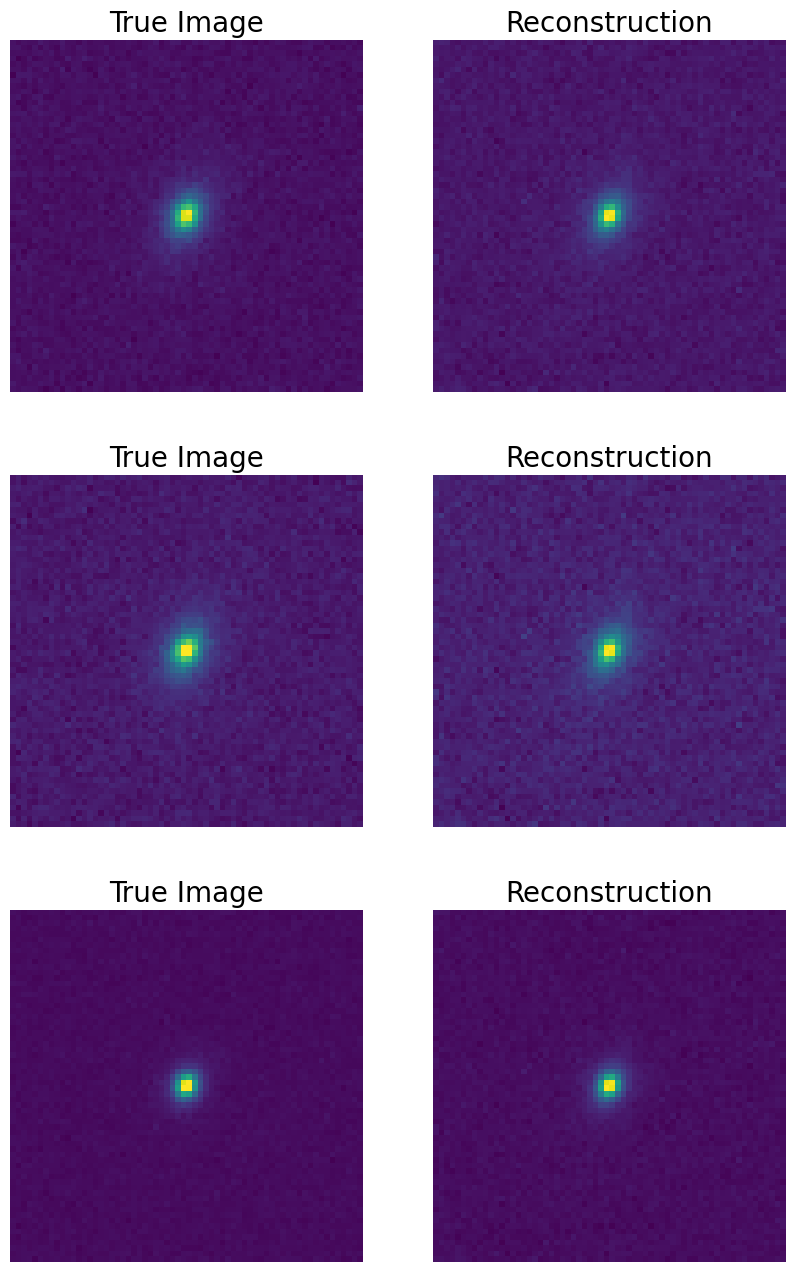

In [0]:

fig, ax = plt.subplots(3, 2, figsize=(10,16))
mpl.style.use('default')

# random images
image_indices = np.random.randint(low=0, high=y_train.shape[0]-1, size=3)

for i, indx in enumerate(image_indices):
  # true image
  ax[i][0].imshow(X_train_norm[indx].reshape(64, 64))
  ax[i][0].set_title('True Image' + str(), fontsize=20)
  ax[i][0].axis('off')
  ax[i][0].grid(False)

  # decoder prediction
  ax[i][1].imshow(AE.predict(y_train_norm[indx].reshape(1, 5))[0])
  ax[i][1].set_title('Reconstruction', fontsize=20)
  ax[i][1].axis('off')
  ax[i][1].grid(False)

In [0]:
import theano.tensor as tt
from theano.compile.ops import as_op

@as_op(itypes=[tt.dscalar] * 5, otypes=[tt.dvector, tt.dmatrix])
def mean_covariance(flux, index, radius, g1, g2):

  # noise variance
  noise_var = 100
  noise_cov = np.diag(np.full(4096, noise_var))

  # Sersic profile
  profile = np.array([flux, index, radius, g1, g2]).reshape(1, 5)

  # mean and variance of each pixel
  mu, cov, _ = encoder.predict(profile)
  mu = mu[0]
  cov = np.diag(cov[0]) + noise_cov

  return mu.astype(np.float64), cov.astype(np.float64)

In [0]:

with pm.Model() as parametric_model:

  # Sersic profile
  flux = pm.Normal('flux', mu=0, sd=100)
  index = pm.Normal('sersic index', mu=0, sd=100)
  radius = pm.Normal('sersic radius', mu=0, sd=100)
  g1 = pm.Normal('g1', mu=0, sd=100)
  g2 = pm.Normal('g2', mu=0, sd=100)

  # parameters of pixels in image with noise included
  mu, cov = mean_covariance(flux, index, radius, g1, g2)

  # distribution of pixels in image with noise
  images = pm.MvNormal('pixels', mu=mu, cov=cov, shape=4096, observed=X_train_norm[0].flatten())

  # trace
  step = pm.Metropolis([flux, index, radius, g1, g2])
  trace = pm.sample(20, tune=10, step=step)

Only 20 samples in chain.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [g2]
>Metropolis: [g1]
>Metropolis: [sersic radius]
>Metropolis: [sersic index]
>Metropolis: [flux]
Sampling chain 1, 0 divergences: 100%|██████████| 30/30 [06:38<00:00, 13.27s/it]
/usr/local/lib/python3.6/dist-packages/pymc3/sampling.py:496: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


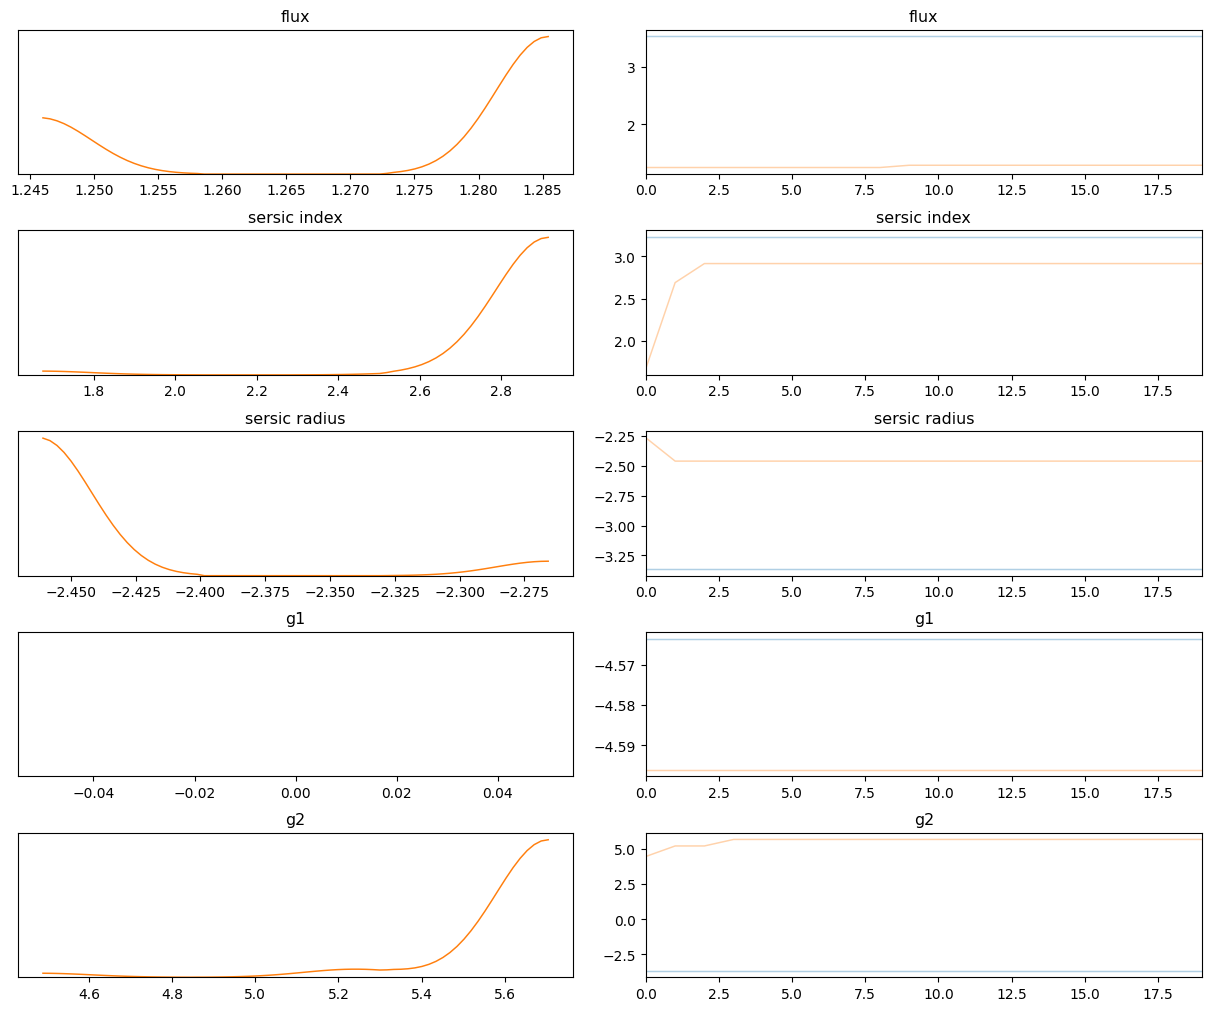

In [0]:

import arviz as az
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
az.plot_trace(trace);

In [0]:
y_train_norm[0]


array([0.62896395, 0.        , 0.61640938, 0.        , 0.        ])